## Logistic Regression

<img src="./images/anime.png" width="500"/>

Вычислительный граф для модели логистической регрессии:

![caption](./images/graph.png)

Алгоритм SGD:

0) инициализируем веса  
1) сэмплируем batch_size примеров из выборки  
2) forward pass: вычисляем значения в узлах вычислительного графа  
3) backward pass: считаем градиенты $\frac{dL}{dw}$ Loss-функции по отношению к параметрам модели  
4) обновляем параметры:  
$$ w := w - lr*\frac{dL}{dw} $$  
5) Если не выполнен критерий завершения (превышено число итераций / параметры перестали существенно изменяться и т.п.), вернуться на шаг 1  

Реализуйте вычисление сигмоиды и постройте ее график в одномерном случае

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [40]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

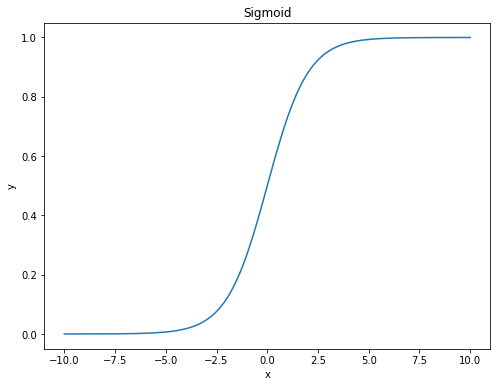

In [41]:
plt.figure(figsize=(8, 6))

x = np.linspace(-10,10,10000)
y = sigmoid(x)

plt.plot(x,y)

plt.title("Sigmoid")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Реализуйте методы fit, predict, BCE, _init_weights в классе LogisticRegression.

In [312]:
class LogisticRegression:
    def __init__(self):
        self.w = None
        self.b = None
        
    @staticmethod
    def sigmoid(x):
        return 1/(1+np.exp(-x))
    
    @staticmethod
    def transform_one_hot(y):
        n_classes = max(y)+1 # classes start from 0
        one_hot = np.zeros(shape=(y.shape[0], n_classes))
        one_hot[tuple((np.arange(y.shape[0]), y))] = 1
        y = one_hot
        return y
    
    @staticmethod
    def loss( y, y_pred, batch_size, w, decay):
        return LogisticRegression.BCE(y, y_pred,batch_size) \
            + 2*(1/batch_size)*decay*np.sum(w*w)*np.ones(batch_size).reshape(batch_size,1)
        
    @staticmethod
    def BCE(y, y_pred, batch_size):
        pred = np.maximum(y_pred, 1e-5)
        return -1*(1/batch_size)*(y*np.log(pred) + (1-y)*np.log(1-pred)) 
    
    @staticmethod
    def sample_batch(X_train, y_train, batch_size):
        if batch_size is not None:
            rand_idx = np.random.permutation(X_train.shape[0])[:batch_size]
            X, y = X_train[rand_idx, ...], y_train[rand_idx, ...]
        else:
            X, y = X_train, y_train
        return X, y
    
    def fit(self, 
            X_train, y_train, 
            iters=10000, 
            lr_base=0.01, 
            steps=4, 
            batch_size=None, 
            print_freq=20,
            decay= 0,
            verbose = True):
        
        """
        fit model to data
        
        params:
            X_train, y_train - training data. Shapes are:
                X_train: (N_samples, N_features),
                y_train: (N_samples, N_classes),
            iters - number of iterations to train
            lr_base - base learning rate
            steps - number of steps to drop the LR
            batch_size - batch size (== X.shape[0] if None)
            weight decay - lambda coefficient for L2 regularization
            print_freq - frequency of logging
        """
        
        self.N = X_train.shape[0]
        self.D = X_train.shape[1]
        self.O = y_train.shape[1]
        if  self.w is None or \
            self.b is None or \
            self.w.shape != (self.D, self.O) or \
            self.b.shape != (1., self.O):
            
            self._init_weights(X_train.shape[1], y_train.shape[1])
            
            #print(f"w  {self.w} \n")
        lr = lr_base
        
        for i in range(iters):
            
            # sample data
            X, y = self.sample_batch(X_train, y_train, batch_size)
            
            # forward pass
            y_pred = self.predict(X)
            
            # backward pass
            loss_ = self.loss(y, y_pred, X.shape[0], self.w, decay)
            grad_w = 1/X.shape[0]*((np.dot(X.T, (y_pred-y))) +decay*self.w)
            grad_b = 1/X.shape[0]*(np.sum(y_pred-y)) 

            # update params
            self.w = self.w - lr*grad_w
            self.b = self.b - lr*grad_b           
            
            if i%steps == 0:
                lr = lr*0.99
                
            # loging
            if i%print_freq == 0 and  verbose:
                print(f'iter: {i}, loss: {np.sum(loss_)}, lr: {lr}')
        return self
    
    def predict(self, X):
        return self.sigmoid(np.dot(X, self.w) + self.b)
    
    def _init_weights(self,D,O):
        self.w = np.random.rand(D, O)*10
        self.b = np.random.rand(1, O)*10

Протестируйте обучение модели на простом примере

In [323]:
X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])
y = np.array([[0], [1], [1], [1]])


model = LogisticRegression()
model = LogisticRegression().fit(X, y, iters=10000, decay=0, steps = 1000, verbose=False)


X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1],
              [1,0]])

model.predict(X)

array([[0.05636223],
       [0.99729613],
       [0.99075568],
       [0.99999849],
       [0.99075568]])

Протестируйте обучение модели на другом примере.

In [332]:
X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])
y = np.array([[0], [1], [1], [0]])

model = LogisticRegression()
model = LogisticRegression().fit(X, y, iters=50000, decay=0.000,steps = 100, verbose=False)

model.predict(X)


array([[0.49999997],
       [0.5       ],
       [0.5       ],
       [0.50000002]])

Каким получается качество? Почему так происходит?

## Боевое применение 

Протестируйте написанную вами модель логистической регрессии на датасете для классификации ирисов. Подробнее об этом датасете: https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0

In [198]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

Разделим данные на обучающую и валидационную выборку. Сконвертируем y в формат one_hot_encoding и обучим модель.

In [347]:
X, y = load_iris(return_X_y=True)
# make y one-hot encoded:
y = LogisticRegression.transform_one_hot(y)
print(X.shape, y.shape, y.min(), y.max())
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1, test_size=0.25)

(150, 4) (150, 3) 0.0 1.0


In [415]:
model = LogisticRegression()
model.fit(X_train, y_train, 
         lr_base=0.1,
         decay=0,
         iters=10000,
         steps = 100, 
         print_freq =1000,
         batch_size=32)

/home/w/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/home/w/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


iter: 0, loss: nan, lr: 0.0999
iter: 1000, loss: 0.6016933068211268, lr: 0.09890548353295386
iter: 2000, loss: 0.8048972227010577, lr: 0.09792086759647052
iter: 3000, loss: 0.5994194259370615, lr: 0.09694605362958227
iter: 4000, loss: 0.5624534671707753, lr: 0.0959809440525076
iter: 5000, loss: 0.7231258633260892, lr: 0.09502544225688342
iter: 6000, loss: 0.5574802370749361, lr: 0.09407945259609449
iter: 7000, loss: 0.6118579864032394, lr: 0.09314288037569907
iter: 8000, loss: 0.5909278903732742, lr: 0.0922156318439499
iter: 9000, loss: 0.4055947528203504, lr: 0.09129761418240961


Подсчитаем точность. Постарайтесь сделать так, чтобы точность была не ниже 85 %. Возможно понадобится покрутить параметры модели (или починить баги :)

In [416]:
pred_val = model.predict(X_val).argmax(axis=1)
gt_val = y_val.argmax(axis=1)
acc = 1 - (pred_val != gt_val).sum() / y_val.shape[0]
print("model accuracy:", acc)

model accuracy: 0.9473684210526316


## Визуализация 

Визуализируйте разделяющую плоскость. Тестируйте на двумерных синтетических данных для простоты дебага и визуализации.

In [401]:
np.random.seed(0)

# create some dummy data
C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.concatenate([np.ones(200, dtype=np.int32), np.zeros(200, dtype=np.int32)])[:, None]

# plot_decision_boundary
model = LogisticRegression().fit(X, y, lr_base=0.01, steps= 100000)


/home/w/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/home/w/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


iter: 0, loss: nan, lr: 0.00999
iter: 20, loss: nan, lr: 0.00999
iter: 40, loss: nan, lr: 0.00999
iter: 60, loss: nan, lr: 0.00999
iter: 80, loss: nan, lr: 0.00999
iter: 100, loss: nan, lr: 0.00999
iter: 120, loss: nan, lr: 0.00999
iter: 140, loss: nan, lr: 0.00999
iter: 160, loss: nan, lr: 0.00999
iter: 180, loss: nan, lr: 0.00999
iter: 200, loss: nan, lr: 0.00999
iter: 220, loss: nan, lr: 0.00999
iter: 240, loss: nan, lr: 0.00999
iter: 260, loss: nan, lr: 0.00999
iter: 280, loss: nan, lr: 0.00999
iter: 300, loss: nan, lr: 0.00999
iter: 320, loss: nan, lr: 0.00999
iter: 340, loss: nan, lr: 0.00999
iter: 360, loss: nan, lr: 0.00999
iter: 380, loss: nan, lr: 0.00999
iter: 400, loss: nan, lr: 0.00999
iter: 420, loss: nan, lr: 0.00999
iter: 440, loss: nan, lr: 0.00999
iter: 460, loss: nan, lr: 0.00999
iter: 480, loss: nan, lr: 0.00999
iter: 500, loss: nan, lr: 0.00999
iter: 520, loss: nan, lr: 0.00999
iter: 540, loss: nan, lr: 0.00999
iter: 560, loss: nan, lr: 0.00999
iter: 580, loss: nan

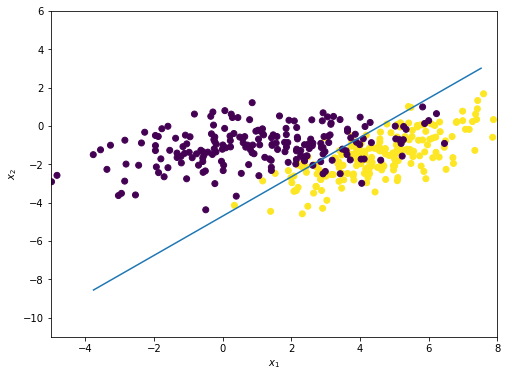

In [402]:

xticks = model.w[0, 0]*np.linspace(-4, 8,100)#+ model.b[0, 0]
yticks =(0.5 - model.w[0, 0]*np.linspace(-4, 8,100) - model.b[0, 0])/model.w[1, 0]

plt.figure(figsize=(8, 6))

plt.scatter(X[:,0], X[:,1], c=y[:, 0])
axes = plt.gca()
axes.set_xlim(-5, 8)
axes.set_ylim(-11, 6)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.plot(xticks, yticks)

Визуализируем также с помощью трехмерного графика как изменяются предсказания модели в зависимости от точки пространства.

Text(0.5, 0, 'prob')

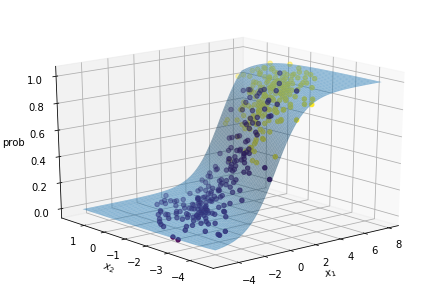

In [403]:
xticks = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
yticks = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)

pred = model.sigmoid(model.w[0, 0]*X[:, 0] + model.w[1, 0]*X[:, 1] + model.b[0, 0])

xxx, yyy = np.meshgrid(xticks, yticks)
zzz = model.sigmoid(model.w[0, 0]*xxx + model.w[1, 0]*yyy + model.b[0, 0])
zticks = model.sigmoid(model.w[0, 0]*xxx + model.w[1, 0]*yyy + model.b[0, 0])


fig = plt.figure(figsize=(6, 4))
ax = Axes3D(fig, azim=-130, elev=20)

ax.scatter(X[:,0], X[:,1], pred, c=y[:, 0])
ax.plot_surface(xxx, yyy, zzz, alpha=0.5)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("prob")